In [36]:
import pandas as pd
import numpy as np
import os
import fnmatch, re

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import stats
from scipy.stats import pearsonr, kendalltau, spearmanr

In [37]:
scipy.__version__

'1.8.0'

In [22]:
def drop_demos(data,data_type,num_row_to_drop):
    data = data.drop(range(0,num_row_to_drop))
    if data_type == "real-fake-judgement":
        data['ground_truth'] = data['ground_truth'].astype(int)
        data = data.replace([0,1],["fake", "real"])
    elif data_type == "SAR":
        data["ground_truth"] = data["ground_truth"].replace(["0","1"],["fake", "real"])
    return data

def process_individual_SAR(file_path, file_name, column_to_read, rows_to_skip):
    participant_file_path = os.path.join(file_path, file_name)
    participant_data = pd.read_csv(participant_file_path, usecols = column_to_read)
    
    participant_data = drop_demos(participant_data, "SAR", rows_to_skip)
    return participant_data

def process_all_people_SAR(file_path, attribute_name):
    files = list(filter(lambda f: os.path.isfile(os.path.join(file_path,f)), os.listdir(file_path)))

    df_stat = pd.DataFrame()
    
    trial_num_path = os.path.join(file_path, files[0])
    print(trial_num_path)
    
    image_info = ["Trial_num","image_name", "image_path","ground_truth"]
    aggregate = pd.read_csv(trial_num_path, usecols = image_info)
    aggregate = drop_demos(aggregate, "SAR", 5)
    
    use_response = ["Trial_num","image_name","image_path", "ground_truth", attribute_name]
    
    for person_data in files:
        if fnmatch.fnmatch(person_data, '*.csv'):
            person_result = process_individual_SAR(file_path, person_data, use_response, 5)
            #Normalize to 0-1 range
            person_result[attribute_name] = (person_result[attribute_name]-person_result[attribute_name].min())/(person_result[attribute_name].max()-person_result[attribute_name].min())
            aggregate = pd.concat([aggregate, person_result[attribute_name]], axis=1)
            all_res_name = attribute_name + "_all"
            aggregate[all_res_name] =  aggregate[aggregate.columns[4]].values.tolist()
            aggregate["mean_rating"] = aggregate[all_res_name].apply(np.mean)
            
    return aggregate

def combine_attributes():
    ## Merge All Attribute Mean ratings
    all_attribute_wide = pd.DataFrame({'image_name':translucency_score['image_name'],
                                    'image_path':translucency_score['image_path'],
                                  'ground_truth':translucency_score['ground_truth'],
                                  'translucency_mean':translucency_score["mean_rating"],
                                  'see_throughness_mean':seethroughness_score["mean_rating"],
                                  'glow_mean':glow_score["mean_rating"]}) 

    all_attribute_long = pd.melt(all_attribute_wide, id_vars=['image_name','image_path','ground_truth'],
                            var_name='attribute', value_name='mean_rating',
            value_vars=['translucency_mean', 'see_throughness_mean','glow_mean'])
    
    return all_attribute_wide, all_attribute_long


def corrfunc(x, y, **kws):
    ## Correlation plots
    r, p = stats.spearmanr(x, y)
    ax = plt.gca()
    # count how many annotations are already present
    n = len([c for c in ax.get_children() if 
                  isinstance(c, matplotlib.text.Annotation)])
    #  make positions for every label by hand
    pos = (.1, .9) if kws['label'] == 'real' else (.1,.85)

    ax.annotate("{}: rho = {:.3f}".format(kws['label'],r),fontsize = 20,
                xy=pos, xycoords=ax.transAxes)
    
def my_hist(x, label, color):
    ax0 = plt.gca()
    ax = ax0.twinx()
    
    sns.despine(ax=ax, left=True, top=True, right=False)
    ax.yaxis.tick_right()
    ax.set_ylabel('Counts')
    
    ax.hist(x, label=label, color=color)

    
def annotate_scatter(data, **kws):
    x = data['mean_rating']
    y = data['dist_norm']
    r, p = stats.pearsonr(x, y)
#     r, p = stats.spearmanr(x, y)
    r, p = round(r,2), round(p,3)
    ax = plt.gca()
    ax.text(.1, .9, f"r = {r}, p = {p}", transform=ax.transAxes)


def plot_svm_predict(file_name):
    #print(os.path.basename(file_name))
    svm_prediction = pd.read_csv(file_name)
    svm_vs_human = all_attributes_wide[all_attributes_wide["ground_truth"] == "fake"].merge(svm_prediction, how='left', on='image_name')

    svm_vs_human["dist_norm"] = (svm_vs_human["distance_bound"]-svm_vs_human["distance_bound"].min())/(svm_vs_human["distance_bound"].max()-svm_vs_human["distance_bound"].min())
    
    r_tran, _ = stats.pearsonr(svm_vs_human['translucency_mean'], svm_vs_human["dist_norm"])  
    r_see, _ = stats.pearsonr(svm_vs_human['see_throughness_mean'], svm_vs_human["dist_norm"])  
    r_glow, _ = stats.pearsonr(svm_vs_human['glow_mean'], svm_vs_human["dist_norm"])  

    
    svm_vs_human_long =  pd.melt(svm_vs_human, id_vars=['image_name','image_path','ground_truth','distance_bound','dist_norm','predicted'],
                                var_name='attribute', value_name='mean_rating',
                value_vars=['translucency_mean', 'see_throughness_mean','glow_mean'])
    
    
    file_name = os.path.basename(file_name)
    sns.color_palette("rocket", as_cmap=True)
    g = sns.FacetGrid(svm_vs_human_long, col="attribute", margin_titles=False, hue = "attribute", hue_order = ["see_throughness_mean","glow_mean", "translucency_mean"],
                      hue_kws=dict(marker=["X", "s", "o"]),
                     palette = "deep")

    g.map_dataframe(sns.scatterplot, x="dist_norm", y="mean_rating", s = 70, alpha = 1)
    g.map_dataframe(annotate_scatter)
    g.set(ylabel='Mean attribute rating', ylim=(0, 1))
    
    plt.xticks([0, 0.5, 1])
    plt.yticks([0, 0.5, 1])
    g.fig.suptitle(file_name)

    return r_tran, r_see, r_glow

    
def plot_r_trend(file_path):
    layer_names, r_trans_layers, r_see_layers, r_glow_layers= [],[],[],[]
    for i in range(18):
        layer_name = str(i)
        path = file_path + str(i) + ".csv"
        r_tran, r_see, r_glow = plot_svm_predict(path)

        layer_names.append(layer_name)
        r_trans_layers.append(np.abs(r_tran))
        r_see_layers.append(np.abs(r_see))
        r_glow_layers.append(np.abs(r_glow))

    r_table = pd.DataFrame({'layer_name':layer_names,
                            'translucent': r_trans_layers,
                            'see-throughness':r_see_layers,
                            'glow':r_glow_layers

                            })

    return r_table


In [5]:
## Read the data
SAR_folder_path = "data/semantic-rating-good-data"

seethroughness_score = process_all_people_SAR(SAR_folder_path, "seethroughness_score.response")
translucency_score = process_all_people_SAR(SAR_folder_path, "translucency_score.response")
glow_score = process_all_people_SAR(SAR_folder_path, "glow_score.response")

data/semantic-rating-good-data/Rory Hayes_SAR-soap_2022_Mar_24_1356.csv
data/semantic-rating-good-data/Rory Hayes_SAR-soap_2022_Mar_24_1356.csv
data/semantic-rating-good-data/Rory Hayes_SAR-soap_2022_Mar_24_1356.csv


# Plot material attribute ratings

In [9]:
## Define color palette for data of real and generated images 
real_fake_color_palette = dict(real="#9b59b6", fake="#95a5a6")

real_fake_hue_order = ["real","fake"]

In [7]:
def plot_hist(df, title):
    plot = sns.histplot(data=df, x="mean_rating", hue="ground_truth",binwidth = 0.2,stat="percent", alpha=0.3,
                                 hue_order=real_fake_hue_order,
                                 shrink=1,common_norm=False,
                                 palette=real_fake_color_palette)
    
    

    plot.set(xticks=np.arange(0,1.2,0.2), yticks=np.arange(0,61,20))


    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1), title='Groun truth')
    sns.set_context(context='poster', font_scale=0.8)
    sns.despine()

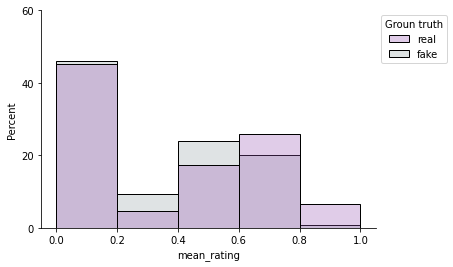

In [10]:
plot_hist(translucency_score, "Trans")


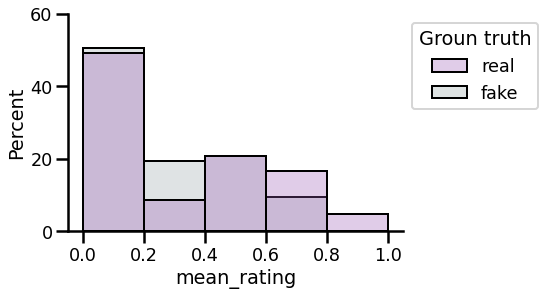

In [11]:
plot_hist(seethroughness_score, "See-throughness")

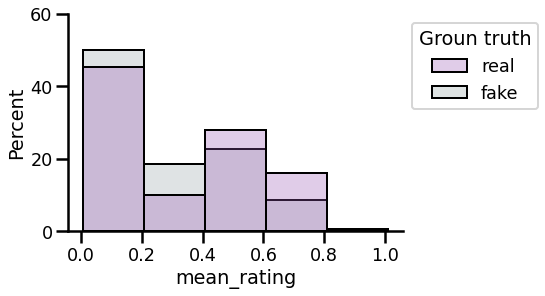

In [12]:
plot_hist(glow_score, "Glow")


In [16]:
## Merge all attributes
all_attributes_wide, all_attribute_long = combine_attributes()

all_attributes_wide[all_attributes_wide["ground_truth"] == "fake"].sort_values(by=['translucency_mean'])

,image_name,image_path,ground_truth,translucency_mean,see_throughness_mean,glow_mean
302,encoded_Group2_IMG_0545.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.000000,0.000000,0.033333
200,encoded_Group2_IMG_9681.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.008333,0.008333,0.041667
139,encoded_Group2_IMG_0139.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.016667,0.008333
34,encoded_Group2_IMG_1025.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.008333,0.033333
115,encoded_Group2_IMG_5433.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.008333,0.025000
...,...,...,...,...,...,...
155,encoded_Group2_IMG_0155.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.763333,0.627500,0.573333
165,encoded_Group2_IMG_9736.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.766667,0.690833,0.553333
66,encoded_Group2_IMG_9726.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.784167,0.762500,0.430000
212,encoded_Group2_IMG_0441.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.788333,0.704167,0.631667


In [80]:
all_attributes_wide.to_csv("human_rating.csv")

# Pair plot

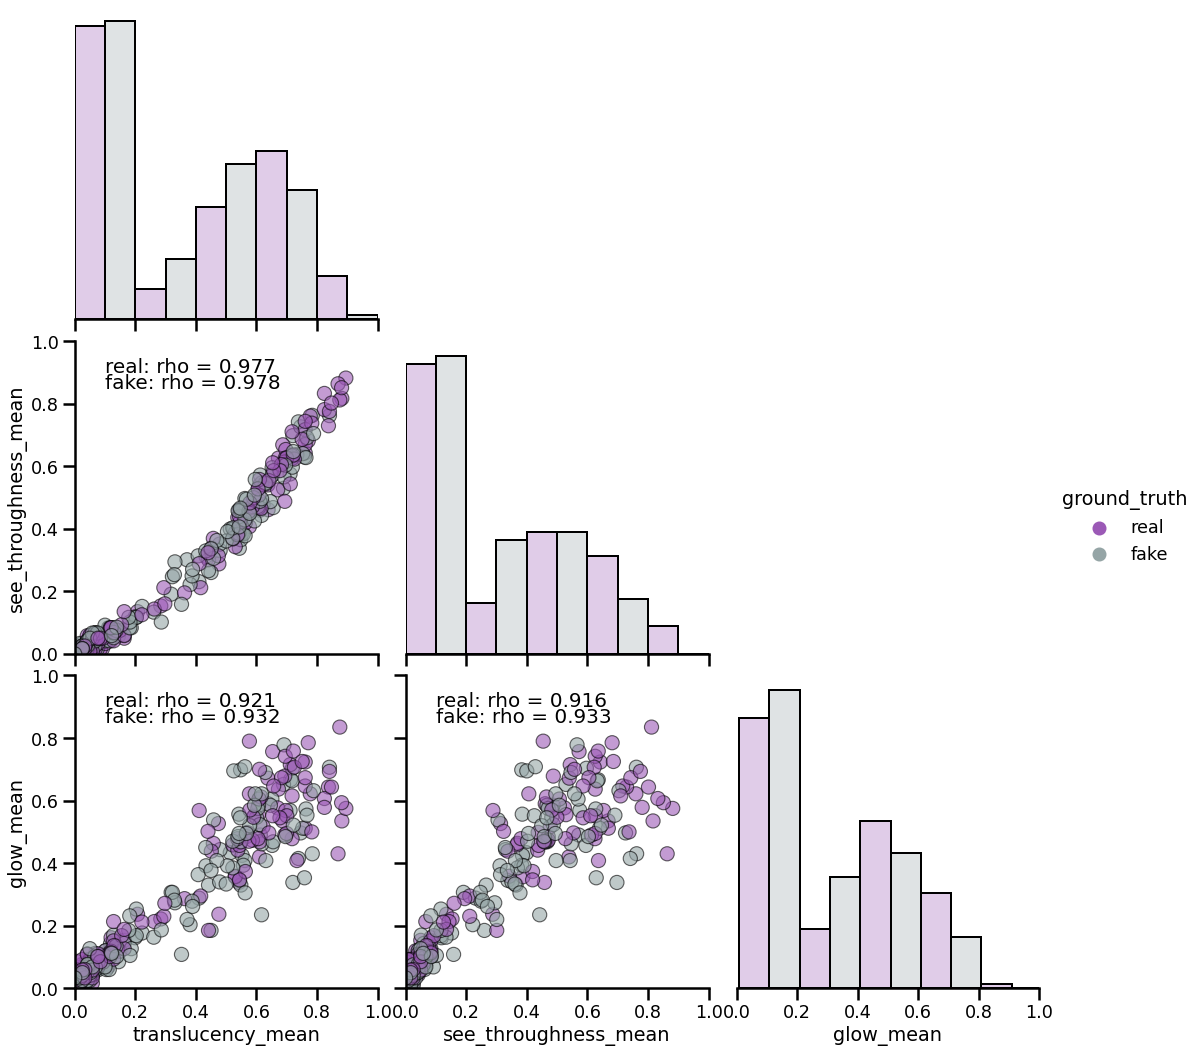

In [18]:
sns.set_context(context='poster', font_scale=0.8)

pair_plot_attribute = sns.pairplot(all_attributes_wide, hue = 'ground_truth', 
             diag_kind = 'hist', markers=["o", "o"],
             palette=real_fake_color_palette,
             hue_order = real_fake_hue_order,
             plot_kws = {'alpha': 0.6, 's': 200, 'edgecolor': 'k'},
             diag_kws = {'alpha': 0.3, 'binwidth' : 0.2, 'multiple' : "dodge", 'kde':False},
             #diag_kws = {'alpha': 0.3, 'binwidth' : 1, 'multiple' : "dodge", 'kde':False},
             grid_kws=dict(diag_sharey=False),                      
             height = 5, corner = True)


pair_plot_attribute = pair_plot_attribute.map_lower(corrfunc)
pair_plot_attribute = pair_plot_attribute.set(xlim=(0, 1), ylim=(0, 1))


# Show images

In [19]:
all_attributes_wide[all_attributes_wide["ground_truth"] == "fake"].sort_values(by=['translucency_mean'])

,image_name,image_path,ground_truth,translucency_mean,see_throughness_mean,glow_mean
302,encoded_Group2_IMG_0545.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.000000,0.000000,0.033333
200,encoded_Group2_IMG_9681.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.008333,0.008333,0.041667
139,encoded_Group2_IMG_0139.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.016667,0.008333
34,encoded_Group2_IMG_1025.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.008333,0.033333
115,encoded_Group2_IMG_5433.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.008333,0.008333,0.025000
...,...,...,...,...,...,...
155,encoded_Group2_IMG_0155.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.763333,0.627500,0.573333
165,encoded_Group2_IMG_9736.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.766667,0.690833,0.553333
66,encoded_Group2_IMG_9726.jpg,Group1-stimuli/group1-block1/fake-group2-b1/en...,fake,0.784167,0.762500,0.430000
212,encoded_Group2_IMG_0441.jpg,Group1-stimuli/group1-block2/fake-group2-b2/en...,fake,0.788333,0.704167,0.631667


# Compare with SVM prediction

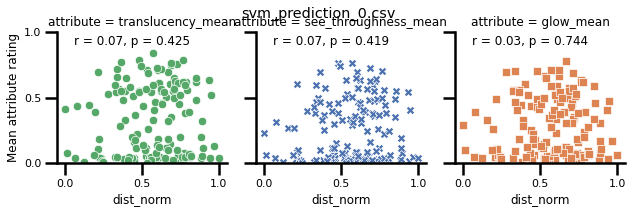

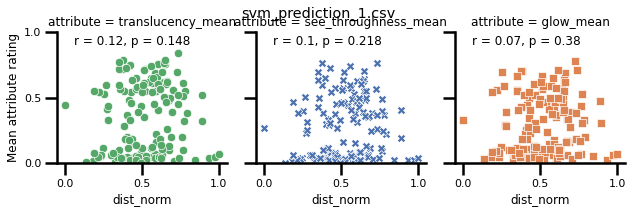

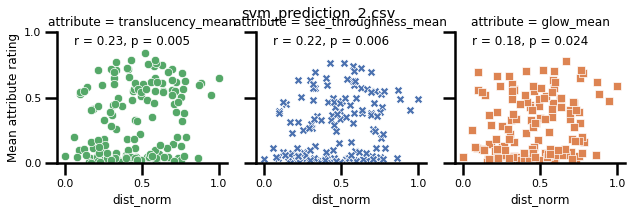

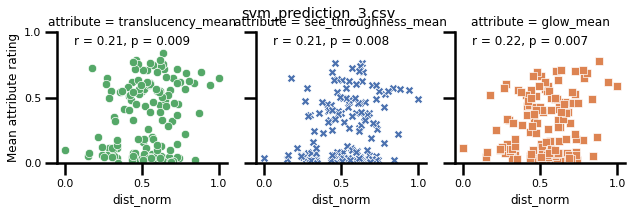

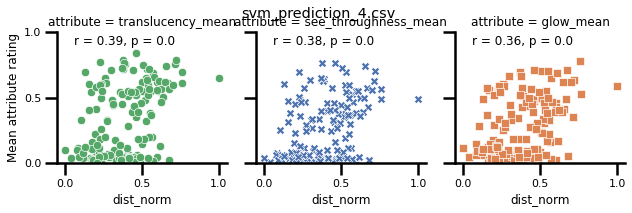

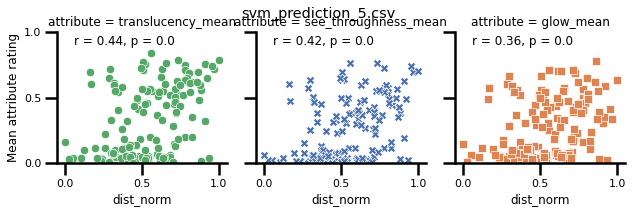

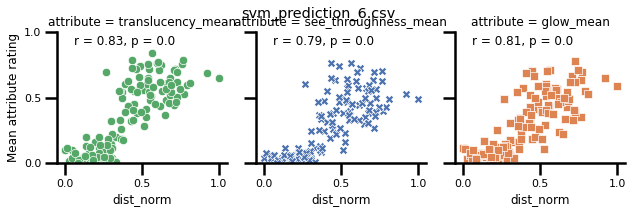

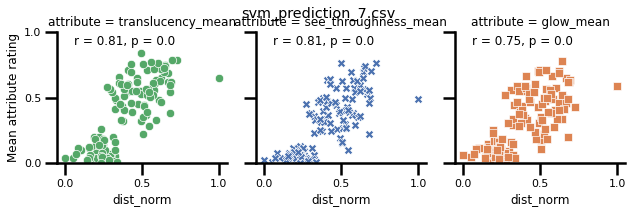

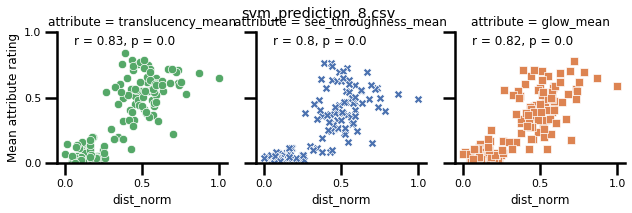

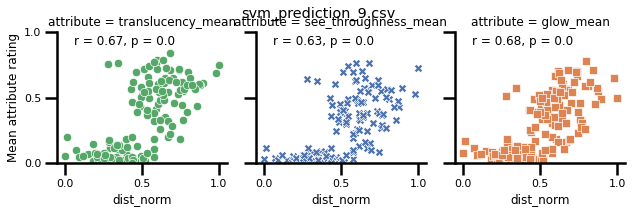

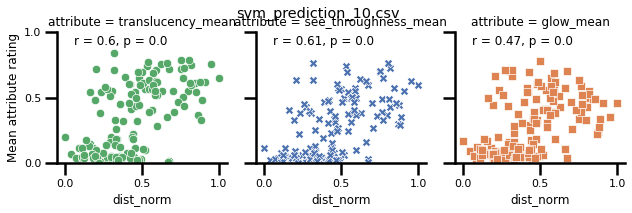

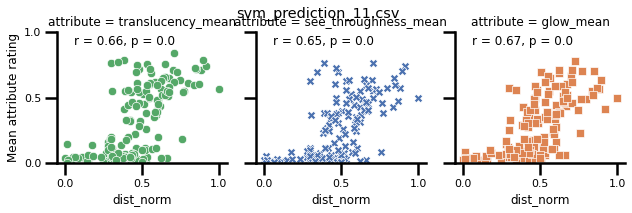

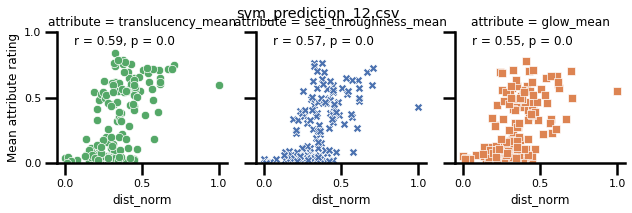

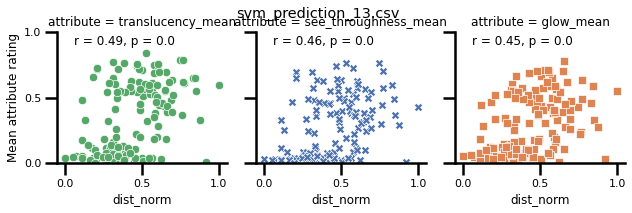

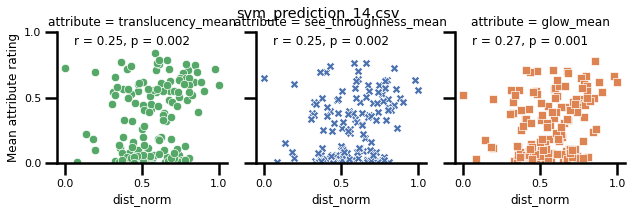

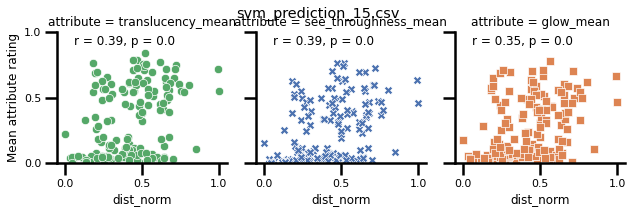

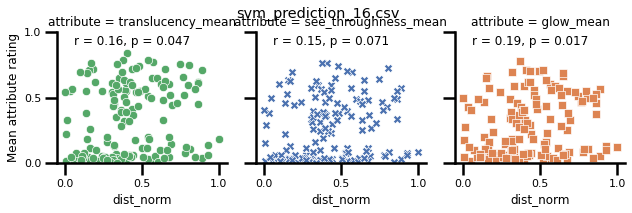

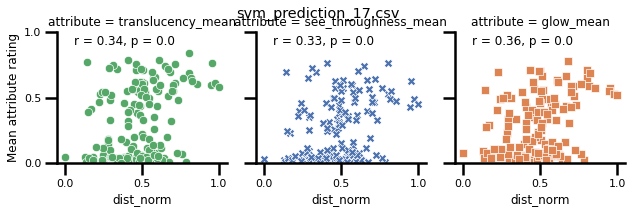

In [23]:
sns.set_context(context='poster', font_scale=0.5)
file_path_svm_pred = "data/svm_c001/svm_prediction_"

r_table = plot_r_trend(file_path_svm_pred)

# Plot layer-wise SVM prediction with human perception

[Text(0.5, 0, 'Layer of W+ latent space'),
 Text(0, 0.5, 'Correlation'),
 Text(0.5, 1.0, 'Correlation with human perception')]

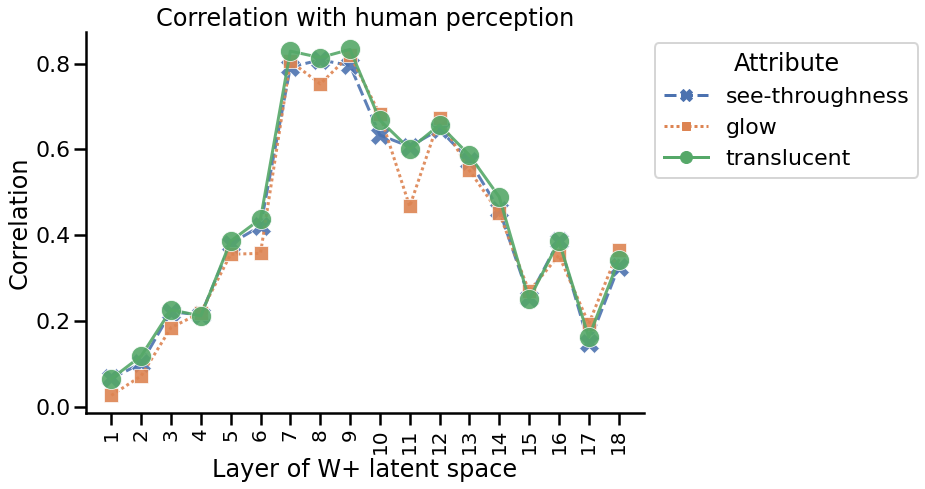

In [26]:
r_trend_long = r_table.melt('layer_name', var_name='attribute', value_name='correlation')


xlabel = list(r_table["layer_name"])

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

sns.set_context(context='poster', font_scale=1)
r_trend = sns.lineplot(
                        data=r_trend_long,
                        x="layer_name", y="correlation", hue="attribute", style="attribute",
                        markers=True, dashes=True, alpha  = 0.9, markersize=20,
                        palette="deep", hue_order = ["see-throughness","glow", "translucent"],
    
                    )

ticks_val = range(18)
tick_val_str = [str(i+1) for i in ticks_val]


plt.xticks(ticks = ticks_val,labels = tick_val_str, rotation=90, fontsize=20)
sns.move_legend(r_trend, "upper left", bbox_to_anchor=(1, 1), title='Attribute')
sns.despine()
r_trend.set(xlabel='Layer of W+ latent space', ylabel='Correlation',
                           title='Correlation with human perception')